In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
from spectral_cube import SpectralCube
from radio_beam import Beam
from astropy.io import fits
import math
from astropy.table import Table

In [2]:
%cd ..
import cutout_manager as cm
import jwst_plots
reload(jwst_plots)
from jwst_plots import JWSTCatalog, make_cat_use, make_cat_refined
from catalog_query import get_catalog
%cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament
/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


# Millimeter YSO Candidates

## Code from Nazar Budaiev

$\frac{M}{M_\odot} = \frac{S_\nu  d^2  c^2}{2 \kappa_\nu \nu^{2} k_B T}$

In [3]:
import astropy.units as u
import astropy.constants as c
def get_mass(flux, freq, d):
    return (flux * d**2 *(c.c**2)/ (2*kappa(freq)*freq**2*c.k_B*T)).to(u.Msun)
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)



<>:6: SyntaxWarning: invalid escape sequence '\k'
<>:6: SyntaxWarning: invalid escape sequence '\k'
/scratch/local/6385955/ipykernel_4002619/492082319.py:6: SyntaxWarning: invalid escape sequence '\k'
  """


In [4]:
# cloud d core
B6freq = 230*u.GHz
kappaB6 = kappa(B6freq)
d = 8*u.kpc
T = 20*u.K
flux = 1.03e-3*u.Jy
get_mass(flux, B6freq, d).to(u.Msun)

<Quantity 1.13580279 solMass>

$\frac{\kappa_0 * \nu}{\nu_0^\beta}$

In [5]:
# Large Filament Core
B3freq = 92.45* u.GHz
kappaB3 = kappa(B3freq)
d = 5*u.kpc
T = 10*u.K
get_mass(0.7*u.mJy, B3freq, d)

<Quantity 18.39425605 solMass>

In [6]:
# Small Filament Core
B3freq = 92.45* u.GHz
kappaB3 = kappa(B3freq)
d = 5*u.kpc
T = 10*u.K
get_mass(0.4*u.mJy, B3freq, d)

<Quantity 10.51100346 solMass>

In [7]:
# Smudge
B3freq = 92.45* u.GHz
kappaB3 = kappa(B3freq)
d = 8.2*u.kpc
T = 20*u.K
get_mass(0.4*u.mJy, B3freq, d)

<Quantity 14.13519745 solMass>

In [8]:
# Cloud c2 core
B3freq = 92.45* u.GHz
kappaB3 = kappa(B3freq)
d = 8.2*u.kpc
T = 20*u.K
get_mass(1*u.mJy, B3freq, d)

<Quantity 35.33799362 solMass>

# Richardson

In [9]:
core1 = SkyCoord('17:46:19.2287619119', '-28:38:29.2978617171', unit=(u.hourangle, u.deg))
core2 = SkyCoord('17:46:19.5945777603', '-28:38:09.9402161687', unit=(u.hourangle, u.deg))

In [10]:
B3_cont_fn = '/orange/adamginsburg/jwst/cloudc/alma/ACES/uid___A001_X15a0_X1a8.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0'

data_3mm_spu_smi = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+24_models-1.2/spu-smi/convolved/user_filters/ALMA-IMF_3mm.fits')
data_3mm_spubhmi = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+24_models-1.2/spubhmi/convolved/user_filters/ALMA-IMF_3mm.fits')
data_3mm_spubsmi = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+24_models-1.2/spubsmi/convolved/user_filters/ALMA-IMF_3mm.fits')
data_3mm_spu_hmi = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+24_models-1.2/spu-hmi/convolved/user_filters/ALMA-IMF_3mm.fits')
apertures = np.logspace(2, 6, 20) * u.AU
parameters_spu_smi = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+24_models-1.2/spu-smi/parameters.fits')
parameters_spubhmi = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+24_models-1.2/spubhmi/parameters.fits')
parameters_spubsmi = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+24_models-1.2/spubsmi/parameters.fits')
parameters_spu_hmi = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+24_models-1.2/spu-hmi/parameters.fits')

In [11]:
parameters_spu_hmi.columns

<TableColumns names=('MODEL_NAME','star.radius','star.temperature','disk.mass','disk.rmax','disk.beta','disk.p','disk.h100','envelope.rho_0','envelope.rc','disk.rmin','envelope.rmin','ambient.density','ambient.temperature','scattering','inclination','Source Luminosity','Line-of-Sight Masses','Sphere Masses','Inner Radius','Outer Radius','Line-of-Sight Mass-Weighted Temperatures','Line-of-Sight Photon-Weighted Temperatures','Sphere Mass-Weighted Temperatures','Av','Disk Minimum Q','Spectral Index')>

In [12]:
apertures

<Quantity [1.00000000e+02, 1.62377674e+02, 2.63665090e+02, 4.28133240e+02,
           6.95192796e+02, 1.12883789e+03, 1.83298071e+03, 2.97635144e+03,
           4.83293024e+03, 7.84759970e+03, 1.27427499e+04, 2.06913808e+04,
           3.35981829e+04, 5.45559478e+04, 8.85866790e+04, 1.43844989e+05,
           2.33572147e+05, 3.79269019e+05, 6.15848211e+05, 1.00000000e+06] AU>

In [13]:
hdu = fits.open(flux_files[0])[0]
hdu.data

NameError: name 'flux_files' is not defined

In [14]:
radius_ang = 1.5*u.arcsec
d = 5*u.kpc
radius_AU = (radius_ang.to(u.rad) * d).to(u.AU, equivalencies=u.dimensionless_angles())
radius_AU

<Quantity 7500. AU>

In [15]:
# flux_5kpc = flux_1kpc / (5 / 1)**2

In [20]:
header = SpectralCube.read(B3_cont_fn, format='casa_image').header
beam = Beam.from_fits_header(header)
beam.major

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


<Quantity 0.00041622 deg>

In [25]:
core_1_sum_5kpc = (3.73e-2 * u.Jy * (beam.major.to(u.arcsec)*beam.minor.to(u.arcsec))**2 / radius_ang**2).value*u.Jy
core_2_sum_5kpc = (2.97e-2 * u.Jy * (beam.major.to(u.arcsec)*beam.minor.to(u.arcsec))**2 / radius_ang**2).value*u.Jy

In [26]:
core_1_sum_5kpc

<Quantity 0.03295061 Jy>

In [27]:
core_1_sum_1kpc = core_1_sum_5kpc * (5 / 1)**2
core_2_sum_1kpc = core_2_sum_5kpc * (5 / 1)**2

In [28]:
core_1_sum_1kpc

<Quantity 0.8237652 Jy>

In [29]:
np.array(data_3mm_spu_smi['TOTAL_FLUX'])[:,9]

array([0.00298696, 0.00298773, 0.00298911, ..., 0.        , 0.        ,
       0.        ], dtype='>f8')

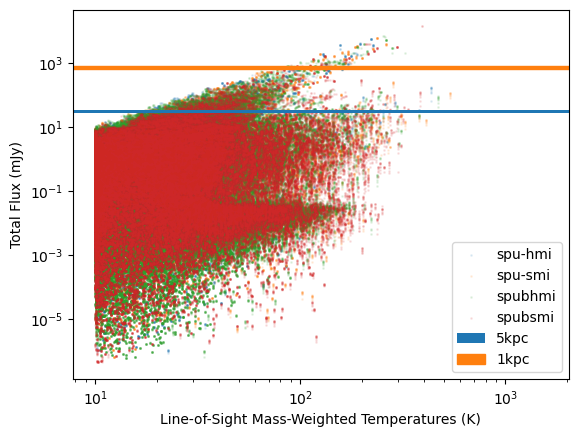

In [33]:
plt.scatter(parameters_spu_hmi['Line-of-Sight Mass-Weighted Temperatures'][:,9], np.array(data_3mm_spu_hmi['TOTAL_FLUX'])[:,9], label='spu-hmi', s=1, alpha=0.1)
plt.scatter(parameters_spu_smi['Line-of-Sight Mass-Weighted Temperatures'][:,9], np.array(data_3mm_spu_smi['TOTAL_FLUX'])[:,9], label='spu-smi', s=1, alpha=0.1)
plt.scatter(parameters_spubhmi['Line-of-Sight Mass-Weighted Temperatures'][:,9], np.array(data_3mm_spubhmi['TOTAL_FLUX'])[:,9], label='spubhmi', s=1, alpha=0.1)
plt.scatter(parameters_spubsmi['Line-of-Sight Mass-Weighted Temperatures'][:,9], np.array(data_3mm_spubsmi['TOTAL_FLUX'])[:,9], label='spubsmi', s=1, alpha=0.1)
plt.xlabel('Line-of-Sight Mass-Weighted Temperatures (K)')
plt.ylabel('Total Flux (mJy)')

plt.xscale('log')
plt.yscale('log')
plt.axhspan(core_1_sum_5kpc.to(u.mJy).value, core_2_sum_5kpc.to(u.mJy).value, label='5kpc')
plt.axhspan(core_1_sum_1kpc.to(u.mJy).value, core_2_sum_1kpc.to(u.mJy).value, label='1kpc', color='tab:orange')
plt.legend()

# IR YSO Candidates

In [9]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt

In [10]:
cand1 = SkyCoord('17:46:18.3752192438', '-28:38:23.6983619088', unit=(u.hourangle, u.deg))
cand2 = SkyCoord('17:46:16.6402575536', '-28:38:31.9988735466', unit=(u.hourangle, u.deg))

In [11]:
#spicy_cat = get_catalog('J/ApJS/254/33/table1', cand1, l=0.5*u.arcmin, w=0.5*u.arcmin)
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = 5e5
spicy_cat = Vizier.query_region(coordinates=cand1, width=1*u.arcmin, height=1*u.arcmin, catalog=['J/ApJS/254/33'])[0]
spicy_positions = SkyCoord(spicy_cat['RA_ICRS'], spicy_cat['DE_ICRS'], unit=(u.deg, u.deg), frame='icrs')
#Vizier.get_catalogs('J/ApJS/254/33')[0]

In [13]:
mass_cat1 = Vizier.query_region(coordinates=cand1, width=3*u.arcsec, height=3*u.arcsec, catalog=['II/295/SSTGC'])[0]
mass_cat2 = Vizier.query_region(coordinates=cand2, width=5*u.arcsec, height=5*u.arcsec, catalog=['II/295/SSTGC'])[0]

mass_cat1_pos = SkyCoord(mass_cat1['RAJ2000'], mass_cat1['DEJ2000'], unit=(u.hour, u.deg), frame='fk5')
mass_cat2_pos = SkyCoord(mass_cat2['RAJ2000'], mass_cat2['DEJ2000'], unit=(u.hour, u.deg), frame='fk5')

In [14]:
mass_cat1

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag  ...  5.8mag  8.0mag IRAC  2M 
                                  mag     mag   ...   mag     mag            
  str7     str11       str11    float32 float32 ... float32 float32 str4 str2
------- ----------- ----------- ------- ------- ... ------- ------- ---- ----
0630841 17 46 18.37 -28 38 23.6      --      -- ...   8.741   7.251 IRAC   2M

In [15]:
mass_cat2

<Table length=1>
 SSTGC    RAJ2000     DEJ2000     Jmag    Hmag  ...  5.8mag  8.0mag IRAC  2M 
                                  mag     mag   ...   mag     mag            
  str7     str11       str11    float32 float32 ... float32 float32 str4 str2
------- ----------- ----------- ------- ------- ... ------- ------- ---- ----
0625944 17 46 16.62 -28 38 31.6      --      -- ...      --   7.497 IRAC   2M

In [16]:
import regions
reg_1 = regions.RectangleSkyRegion(cand1, 10*u.arcsec, 10*u.arcsec)
reg_2 = regions.RectangleSkyRegion(cand2, 10*u.arcsec, 10*u.arcsec)

In [17]:
cutout_1_405 = cm.get_cutout_405(cand1, 5*u.arcsec, 5*u.arcsec)
cutout_2_405 = cm.get_cutout_405(cand2, 5*u.arcsec, 5*u.arcsec)

cutout_1_466 = cm.get_cutout_466(cand1, 5*u.arcsec, 5*u.arcsec)
cutout_2_466 = cm.get_cutout_466(cand2, 5*u.arcsec, 5*u.arcsec)

cutout_1_187 = cm.get_cutout_187(cand1, 5*u.arcsec, 5*u.arcsec)
cutout_2_187 = cm.get_cutout_187(cand2, 5*u.arcsec, 5*u.arcsec)

cutout_1_212 = cm.get_cutout_212(cand1, 5*u.arcsec, 5*u.arcsec)
cutout_2_212 = cm.get_cutout_212(cand2, 5*u.arcsec, 5*u.arcsec)

In [18]:
cat_1 = spicy_cat[reg_1.contains(spicy_positions, cutout_1_405.wcs)]
cat_2 = spicy_cat[reg_2.contains(spicy_positions, cutout_2_405.wcs)]

In [19]:
cutout_1_rgb, wcs_1 = cm.get_cutout_rgb(cand1, 5*u.arcsec, 5*u.arcsec)
cutout_2_rgb, wcs_2 = cm.get_cutout_rgb(cand2, 5*u.arcsec, 5*u.arcsec)

cutout_1_rgb3, wcs3_1 = cm.get_cutout_rgb3(cand1, 5*u.arcsec, 5*u.arcsec)
cutout_2_rgb3, wcs3_2 = cm.get_cutout_rgb3(cand2, 5*u.arcsec, 5*u.arcsec)

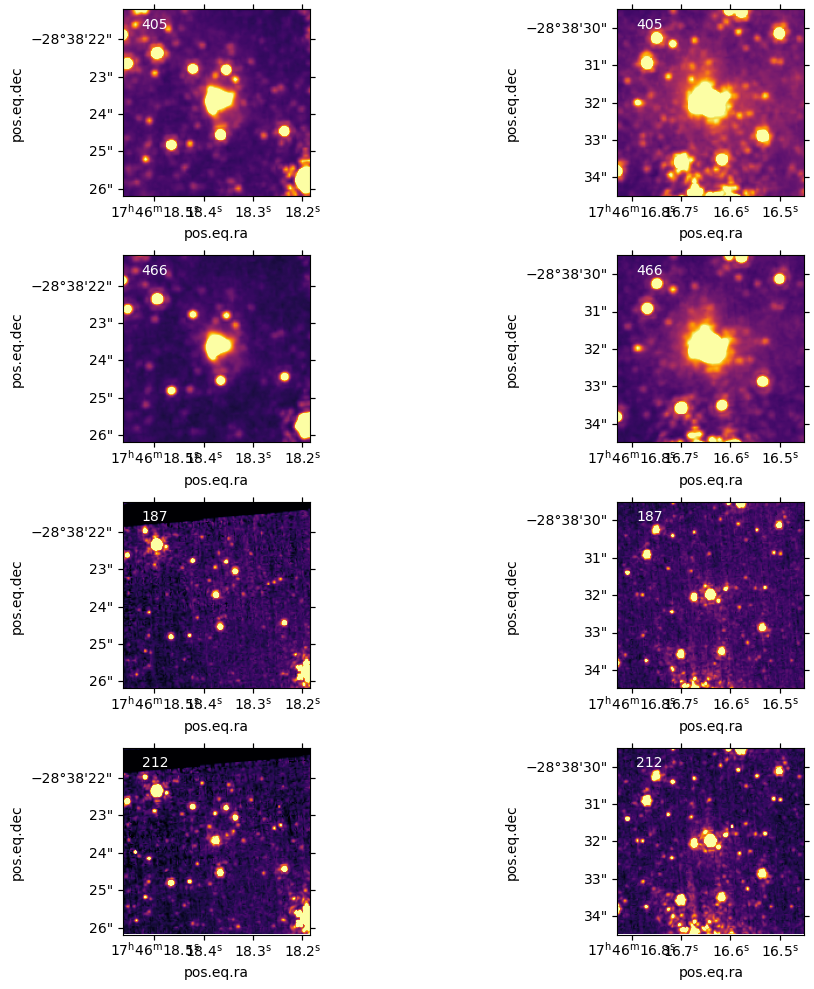

In [20]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(421, projection=cutout_1_405.wcs)
ax.imshow(cutout_1_405.data, origin='lower', cmap='inferno', vmin=0, vmax=100)
ax.text(0.1, 0.9, '405', color='white', transform=ax.transAxes)

ax = plt.subplot(422, projection=cutout_2_405.wcs)
ax.imshow(cutout_2_405.data, origin='lower', cmap='inferno', vmin=0, vmax=100)
ax.text(0.1, 0.9, '405', color='white', transform=ax.transAxes)

ax = plt.subplot(423, projection=cutout_1_466.wcs)
ax.imshow(cutout_1_466.data, origin='lower', cmap='inferno', vmin=0, vmax=100)
ax.text(0.1, 0.9, '466', color='white', transform=ax.transAxes)

ax = plt.subplot(424, projection=cutout_2_466.wcs)
ax.imshow(cutout_2_466.data, origin='lower', cmap='inferno', vmin=0, vmax=100)
ax.text(0.1, 0.9, '466', color='white', transform=ax.transAxes)

ax = plt.subplot(425, projection=cutout_1_187.wcs)
ax.imshow(cutout_1_187.data, origin='lower', cmap='inferno', vmin=0, vmax=100)
ax.text(0.1, 0.9, '187', color='white', transform=ax.transAxes)

ax = plt.subplot(426, projection=cutout_2_187.wcs)
ax.imshow(cutout_2_187.data, origin='lower', cmap='inferno', vmin=0, vmax=100)
ax.text(0.1, 0.9, '187', color='white', transform=ax.transAxes)

ax = plt.subplot(427, projection=cutout_1_212.wcs)
ax.imshow(cutout_1_212.data, origin='lower', cmap='inferno', vmin=0, vmax=100)
ax.text(0.1, 0.9, '212', color='white', transform=ax.transAxes)

ax = plt.subplot(428, projection=cutout_2_212.wcs)
ax.imshow(cutout_2_212.data, origin='lower', cmap='inferno', vmin=0, vmax=100)
ax.text(0.1, 0.9, '212', color='white', transform=ax.transAxes)

plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


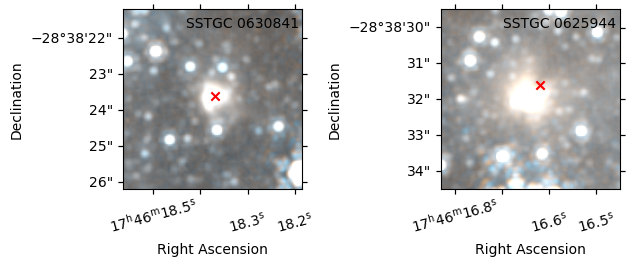

In [50]:
ax = plt.subplot(121, projection=wcs_1)
ax.imshow(cutout_1_rgb, origin='lower', cmap='inferno')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.coords[0].set_ticklabel(exclude_overlapping=True, rotation=15, pad=20)
ax.scatter(mass_cat1_pos.ra, mass_cat1_pos.dec, color='r', marker='x', transform=ax.get_transform('world'))
ax.text(0.35, 0.9, 'SSTGC 0630841', color='k', transform=ax.transAxes)
#ax.scatter(, s=50, color='r', marker='x', transform=ax.get_transform('world'))

ax = plt.subplot(122, projection=wcs_2)
ax.imshow(cutout_2_rgb, origin='lower', cmap='inferno')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.coords[0].set_ticklabel(exclude_overlapping=True, rotation=15, pad=20)
ax.scatter(mass_cat2_pos.ra, mass_cat2_pos.dec, color='r', marker='x', transform=ax.get_transform('world'))
ax.text(0.35, 0.9, 'SSTGC 0625944', color='k', transform=ax.transAxes)
#ax.scatter(cat_2['RA_ICRS']*u.deg, cat_2['DE_ICRS']*u.deg, s=50, color='r', marker='x', transform=ax.get_transform('world'))

plt.tight_layout()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/yso_candidates_rgb.pdf', bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/yso_candidates_rgb.png', bbox_inches='tight')

In [22]:
cutout_spit_1, ww_s1 = cm.get_cutout_glimpse_rgb(cand1, 15*u.arcsec, 15*u.arcsec)
cutout_spit_2, ww_s2 = cm.get_cutout_glimpse_rgb(cand2, 15*u.arcsec, 15*u.arcsec)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


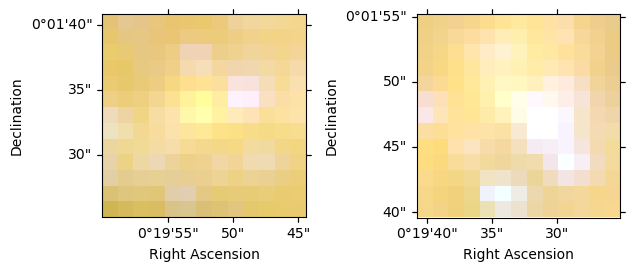

In [23]:
ax = plt.subplot(121, projection=ww_s1)
ax.imshow(cutout_spit_1, origin='lower', cmap='inferno')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

ax = plt.subplot(122, projection=ww_s2)
ax.imshow(cutout_spit_2, origin='lower', cmap='inferno')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


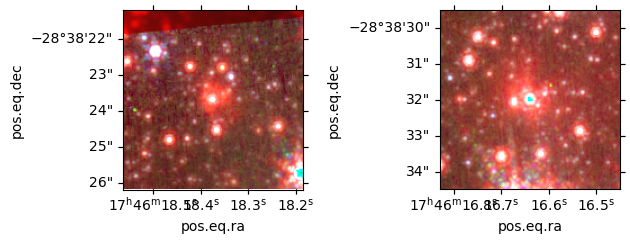

In [24]:
ax = plt.subplot(121, projection=wcs3_1)
ax.imshow(cutout_1_rgb3, origin='lower', cmap='inferno')

ax = plt.subplot(122, projection=wcs3_2)
ax.imshow(cutout_2_rgb3, origin='lower', cmap='inferno')

plt.tight_layout()

In [25]:
mag_405 = 13.524
mag_187 = 16.5
mag_466 = 13.499
mag_212 = 15.5
from dust_extinction.averages import CT06_MWGC

In [26]:
(mag_187-mag_405)/(CT06_MWGC()(1.87*u.um)-CT06_MWGC()(4.05*u.um))

34.94828112573376

In [27]:
cat_use = make_cat_use()

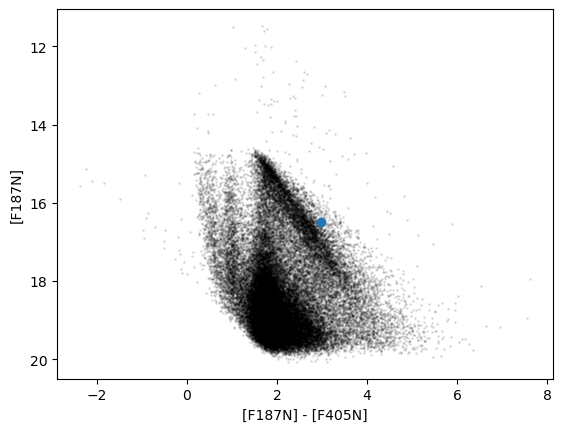

In [28]:
cat_use.plot_CMD('f187n', 'f405n', 'f187n', s=1, color='k', alpha=0.1)
plt.scatter(mag_187-mag_405, mag_187)

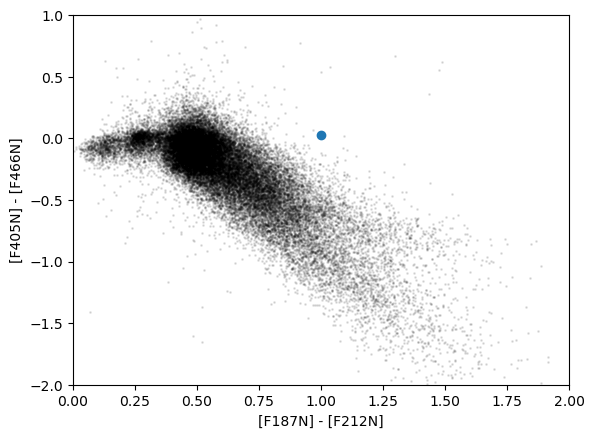

In [29]:
ax = plt.subplot(111)
cat_use.plot_CCD('f187n', 'f212n', 'f405n', 'f466n', s=1, color='k', alpha=0.1, ax=ax)
ax.set_xlim(0, 2)
ax.set_ylim(-2, 1)

ax.scatter(mag_187-mag_212, mag_405-mag_466)

# F410M-F466N Selection of YSO candidates

In [30]:
import regions
import numpy as np
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

cutout_filament = cm.Cutout(pos, w, l)
cutout_405 = cutout_filament.get_cutout_405()

In [44]:
ysocands = Vizier.query_region(coordinates=pos, width=l, height=w, catalog=['J/ApJ/702/178/YSOcand'])[0]
ysocands

<Table length=2>
SSTGC  n_SSTGC   GLON     GLAT     Chi2  ... 2M/IRAC Simbad _RA.icrs  _DE.icrs
                 deg      deg            ...                  deg       deg   
int32    str3  float64  float64  float32 ...   str7   str6  float64   float64 
------ ------- -------- -------- ------- ... ------- ------ -------- ---------
630480           0.3268   0.0238    5.97 ... 2M/IRAC Simbad 266.5759 -28.64473
630841           0.3311   0.0258    0.00 ... 2M/IRAC Simbad 266.5765 -28.64001

In [32]:
spicy_cat = Vizier.query_region(coordinates=pos, width=l, height=w, catalog=['J/ApJS/254/33'])[0]
spicy_positions = SkyCoord(spicy_cat['RA_ICRS'], spicy_cat['DE_ICRS'], unit=(u.deg, u.deg), frame='icrs')
spicy_filament_cat = spicy_cat[reg.contains(spicy_positions, cutout_405.wcs)]

In [33]:
cat_ref = make_cat_refined()

In [34]:
cat_filament = JWSTCatalog(cat_ref.table_region_mask([reg], cutout_405.wcs))
mask_red = (cat_filament.color('f182m', 'f212n') > 0.55) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
cat_filament = JWSTCatalog(cat_filament.catalog[mask_red])

In [35]:
mask_yso_cands = cat_filament.color('f182m', 'f212n') > 0.55
mask_yso_cands = np.logical_and(mask_yso_cands, cat_filament.color('f182m', 'f410m') > 2)
mask_yso_cands = np.logical_and(mask_yso_cands, cat_filament.color('f410m', 'f466n') > 0.5)
#(cat_filament.color('f187n', 'f212n') > 0.55) & (cat_filament.color('f410m', 'f466n') > 0.5) & )
cat_yso_cands = JWSTCatalog(cat_filament.catalog[mask_yso_cands])

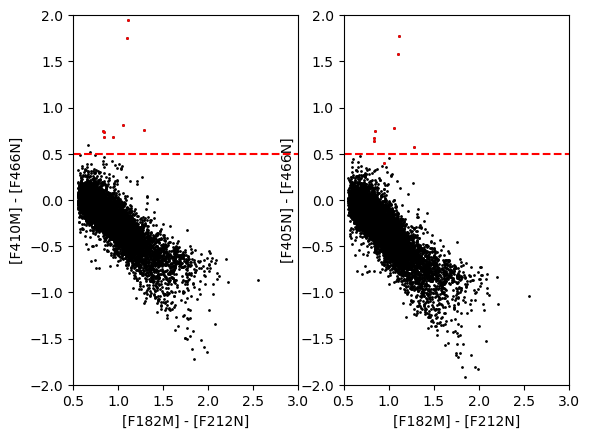

In [36]:
ax = plt.subplot(121)
cat_filament.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', s=1, color='k', ax=ax)
cat_yso_cands.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', s=1, color='red', ax=ax)
ax.set_xlim(0.5, 3)
ax.set_ylim(-2, 2)
ax.axhline(0.5, color='r', ls='--')

ax = plt.subplot(122)
cat_filament.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, color='k', ax=ax)
cat_yso_cands.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, color='red', ax=ax)
ax.set_xlim(0.5, 3)
ax.set_ylim(-2, 2)
ax.axhline(0.5, color='r', ls='--')

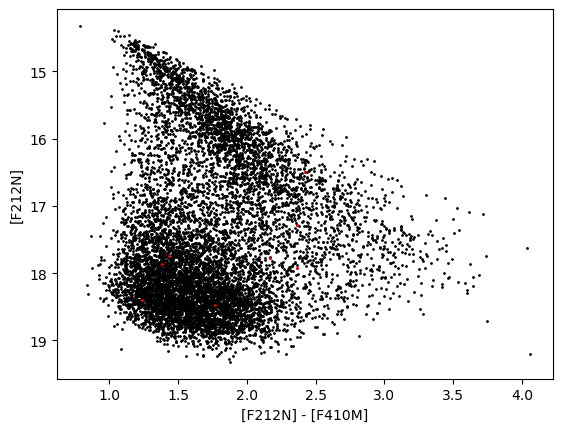

In [37]:
ax = plt.subplot(111)
cat_filament.plot_CMD('f212n', 'f410m', 'f212n', s=1, color='k', ax=ax)
cat_yso_cands.plot_CMD('f212n', 'f410m', 'f212n', s=1, color='red', ax=ax)
plt.gca().invert_yaxis()

<WCSAxes: >

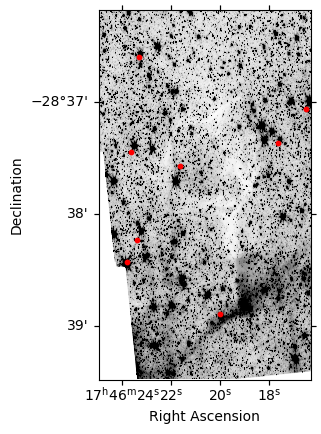

In [38]:
ax = plt.subplot(projection=cutout_405.wcs)
ax.imshow(cutout_405.data, origin='lower', cmap='Greys', vmin=0, vmax=50)
#plt.scatter(cat_yso_cands.ra, cat_yso_cands.dec, s=10, color='red', alpha=0.5, transform=ax.get_transform('world'))
cat_yso_cands.plot_position(s=10, color='red', ax=ax, transform=ax.get_transform('world'))

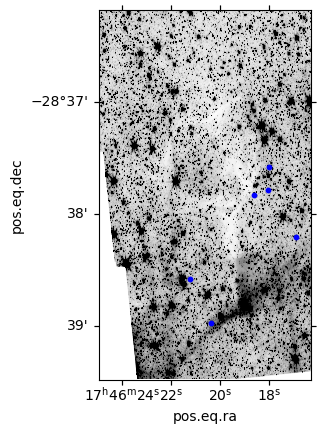

In [39]:
ax = plt.subplot(projection=cutout_405.wcs)
ax.imshow(cutout_405.data, origin='lower', cmap='Greys', vmin=0, vmax=50)
#plt.scatter(cat_yso_cands.ra, cat_yso_cands.dec, s=10, color='red', alpha=0.5, transform=ax.get_transform('world'))
#cat_yso_cands.plot_position(s=10, color='red', ax=ax, transform=ax.get_transform('world'))
spicy_filament_positions = SkyCoord(spicy_filament_cat['RA_ICRS'], spicy_filament_cat['DE_ICRS'], unit=(u.deg, u.deg), frame='icrs')
ax.scatter(spicy_filament_positions.ra, spicy_filament_positions.dec, s=10, color='b', transform=ax.get_transform('world'))

In [45]:
ysocands_pos = SkyCoord(ysocands['_RA.icrs'], ysocands['_DE.icrs'], unit=(u.deg, u.deg), frame='icrs')
#SkyCoord(ysocands['GLON'], ysocands['GLAT'], unit=(u.deg, u.deg), frame='galactic')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


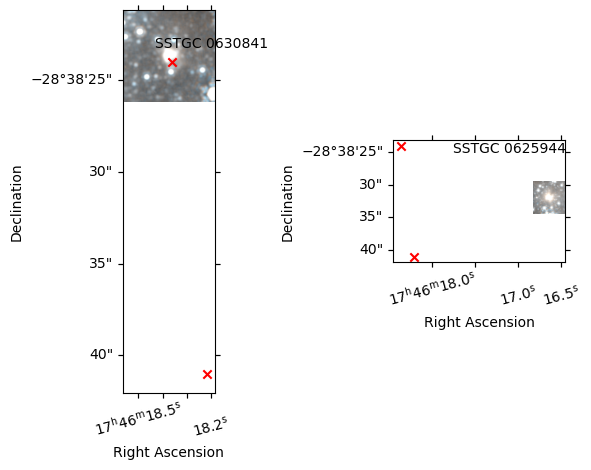

In [ ]:
ax = plt.subplot(121, projection=wcs_1)
ax.imshow(cutout_1_rgb, origin='lower', cmap='inferno')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.coords[0].set_ticklabel(exclude_overlapping=True, rotation=15, pad=20)
ax.scatter(ysocands_pos.ra, ysocands_pos.dec, color='r', marker='x', transform=ax.get_transform('world'))
ax.text(0.35, 0.9, 'SSTGC 0630841', color='k', transform=ax.transAxes)
#ax.scatter(, s=50, color='r', marker='x', transform=ax.get_transform('world'))

ax = plt.subplot(122, projection=wcs_2)
ax.imshow(cutout_2_rgb, origin='lower', cmap='inferno')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.coords[0].set_ticklabel(exclude_overlapping=True, rotation=15, pad=20)
ax.scatter(ysocands_pos.ra, ysocands_pos.dec, color='r', marker='x', transform=ax.get_transform('world'))
ax.text(0.35, 0.9, 'SSTGC 0625944', color='k', transform=ax.transAxes)
#ax.scatter(cat_2['RA_ICRS']*u.deg, cat_2['DE_ICRS']*u.deg, s=50, color='r', marker='x', transform=ax.get_transform('world'))

plt.tight_layout()
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/yso_candidates_rgb.pdf', bbox_inches='tight')
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/yso_candidates_rgb.png', bbox_inches='tight')

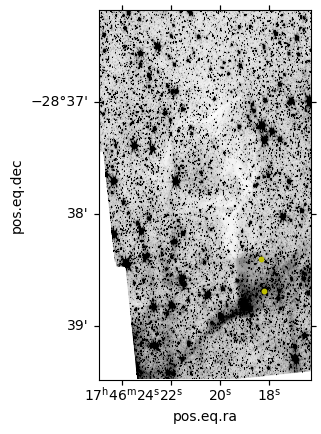

In [49]:
ax = plt.subplot(projection=cutout_405.wcs)
ax.imshow(cutout_405.data, origin='lower', cmap='Greys', vmin=0, vmax=50)
#plt.scatter(cat_yso_cands.ra, cat_yso_cands.dec, s=10, color='red', alpha=0.5, transform=ax.get_transform('world'))
#cat_yso_cands.plot_position(s=10, color='red', ax=ax, transform=ax.get_transform('world'))
ax.scatter(ysocands_pos.ra, ysocands_pos.dec, s=10, color='y', transform=ax.get_transform('world'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


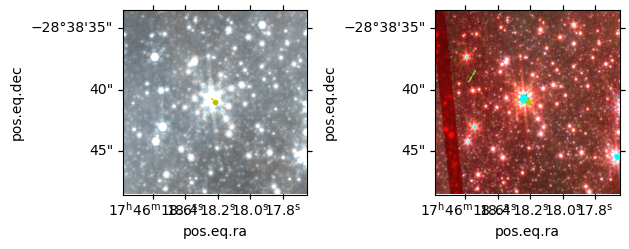

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


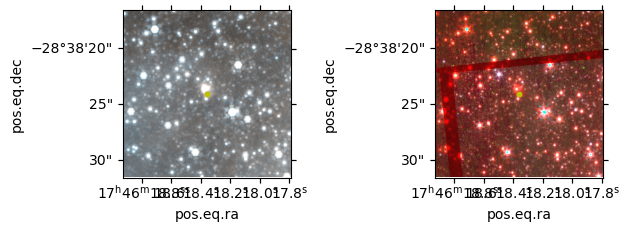

In [53]:
#ysocands_pos
for i in range(len(ysocands_pos)):
    cutout, ww = cm.get_cutout_rgb(ysocands_pos[i], 15*u.arcsec, 15*u.arcsec)
    ax = plt.subplot(121, projection=ww)
    ax.imshow(cutout)
    ax.scatter(ysocands_pos[i].ra, ysocands_pos[i].dec, s=10, color='y', transform=ax.get_transform('world'))
    cutout, ww = cm.get_cutout_rgb3(ysocands_pos[i], 15*u.arcsec, 15*u.arcsec)
    ax = plt.subplot(122, projection=ww)
    ax.imshow(cutout)
    ax.scatter(ysocands_pos[i].ra, ysocands_pos[i].dec, s=10, color='y', transform=ax.get_transform('world'))
    plt.tight_layout()

    plt.show()

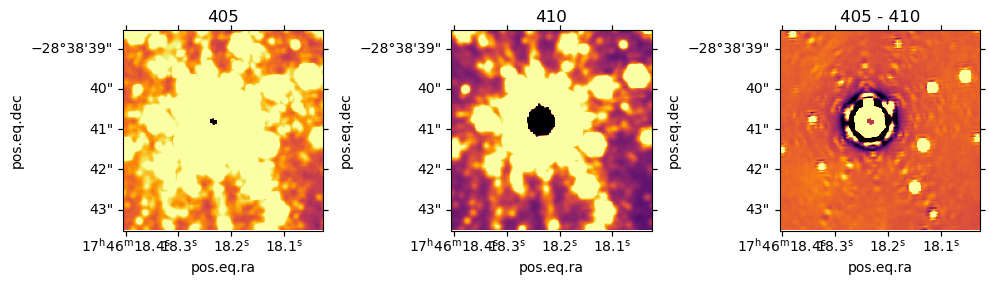

In [62]:
fig = plt.figure(figsize=(10, 10))
cutout_yz1_405 = cm.get_cutout_405(ysocands_pos[0], 5*u.arcsec, 5*u.arcsec)
cutout_yz1_410 = cm.get_cutout_410(ysocands_pos[0], 5*u.arcsec, 5*u.arcsec)

ax = plt.subplot(131, projection=cutout_yz1_405.wcs)
ax.imshow(cutout_yz1_405.data, origin='lower', cmap='inferno', vmin=0, vmax=50)
ax.set_title('405')
ax = plt.subplot(132, projection=cutout_yz1_410.wcs)
ax.imshow(cutout_yz1_410.data, origin='lower', cmap='inferno', vmin=0, vmax=50)
ax.set_title('410')
ax = plt.subplot(133, projection=cutout_yz1_405.wcs)
diff = cutout_yz1_405.data - cutout_yz1_410.data
ax.imshow(diff, origin='lower', cmap='inferno', vmin=-50, vmax=50)
ax.set_title('405 - 410')
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


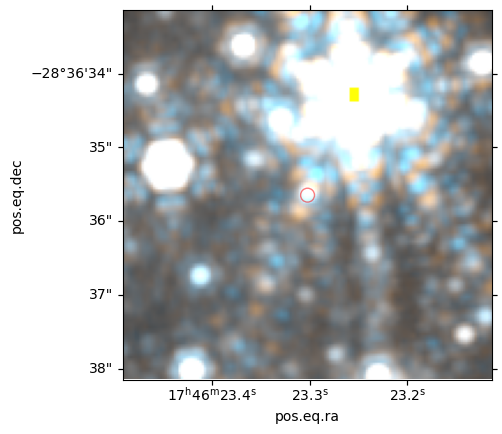

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


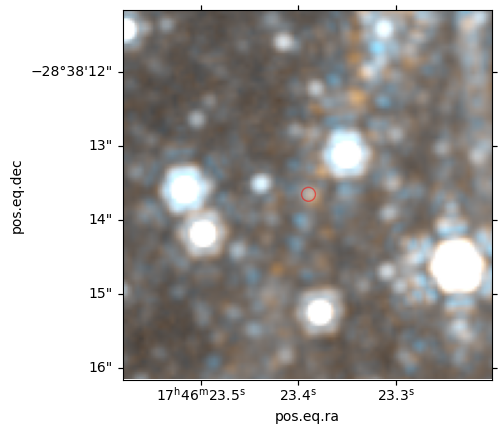

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


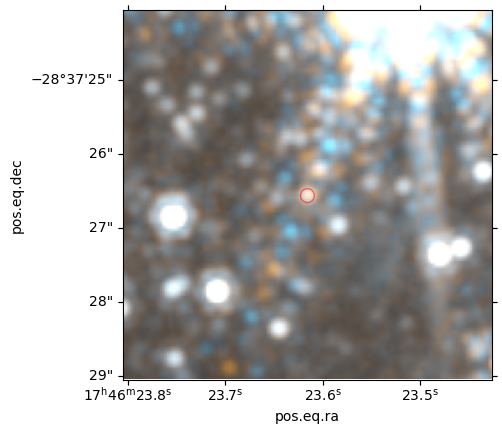

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


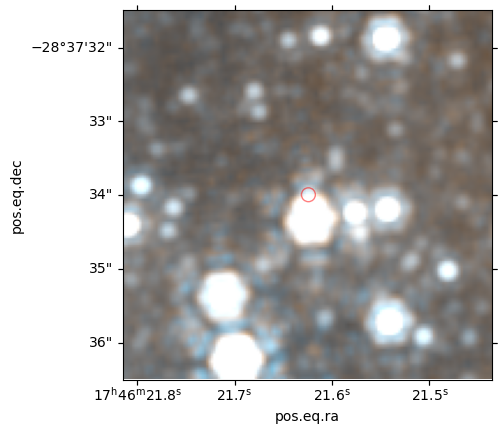

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


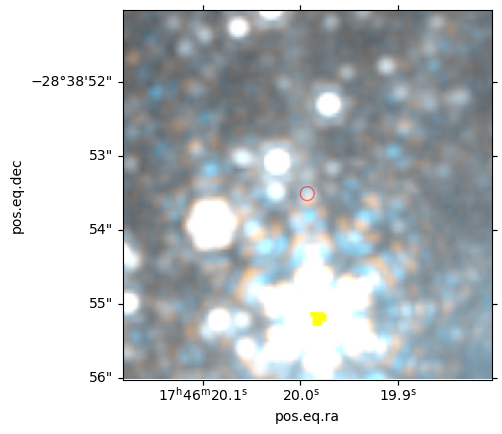

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


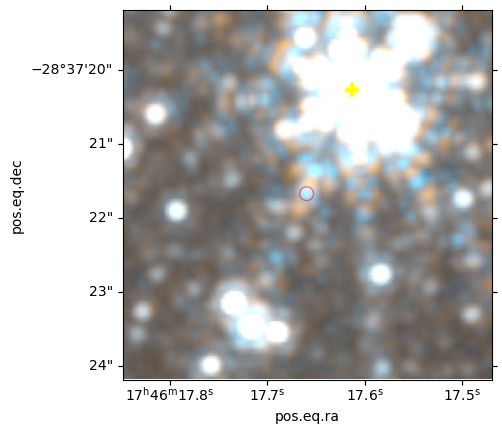

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


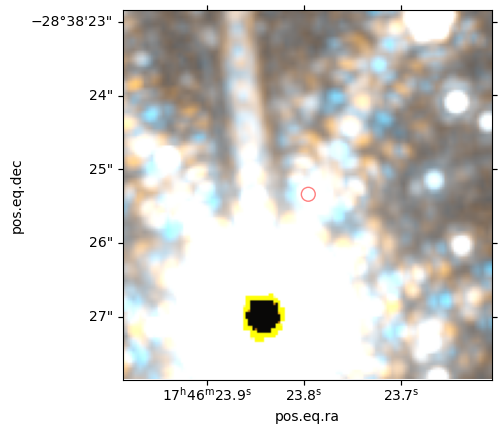

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


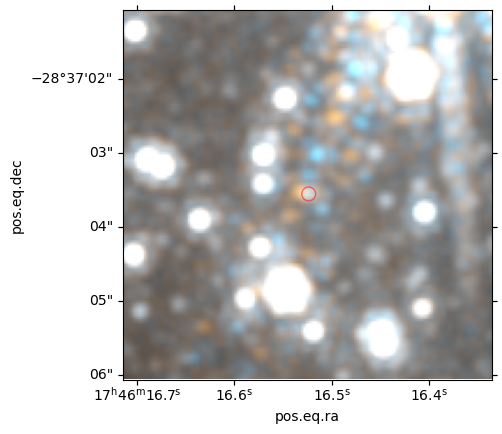

In [ ]:
for i in range(len(cat_yso_cands.catalog)):
    cutout, ww = cm.get_cutout_rgb(cat_yso_cands.catalog[i]['skycoord_ref'], 5*u.arcsec, 5*u.arcsec)
    ax = plt.subplot(111, projection=ww)
    ax.imshow(cutout.data)
    ax.scatter(cat_yso_cands.catalog[i]['skycoord_ref'].ra, cat_yso_cands.catalog[i]['skycoord_ref'].dec, s=100, edgecolor='red', facecolor='none', alpha=0.5, transform=ax.get_transform('world'))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


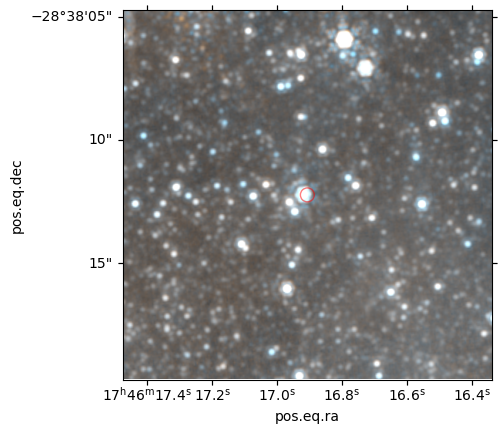

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


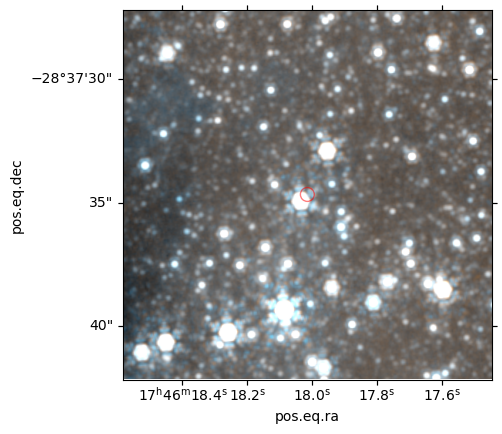

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


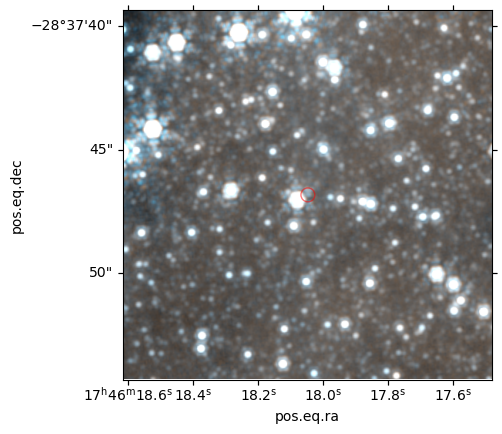

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


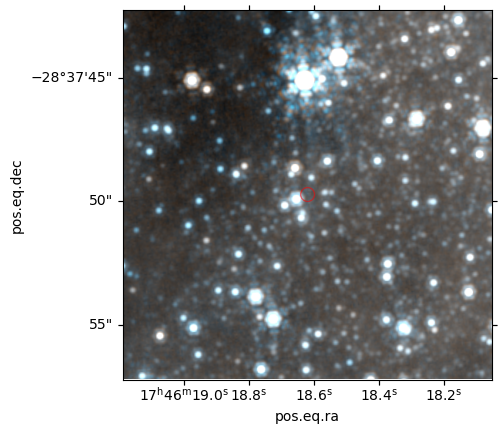

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


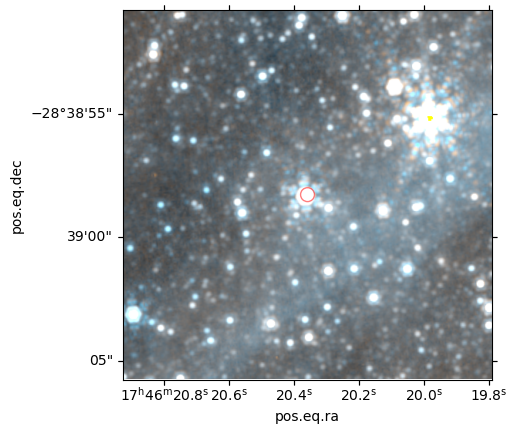

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


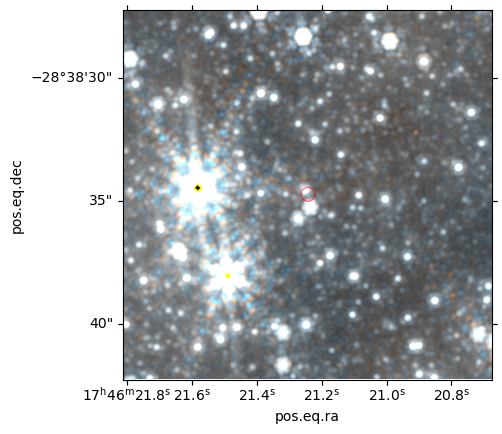

In [52]:
for i in range(len(spicy_filament_positions)):
    cutout, ww = cm.get_cutout_rgb(spicy_filament_positions[i], 15*u.arcsec, 15*u.arcsec)
    ax = plt.subplot(111, projection=ww)
    ax.imshow(cutout.data, origin='lower', cmap='Greys', vmin=0, vmax=50)
    ax.scatter(spicy_filament_positions[i].ra, spicy_filament_positions[i].dec, s=100, edgecolor='red', facecolor='none', alpha=0.5, transform=ax.get_transform('world'))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


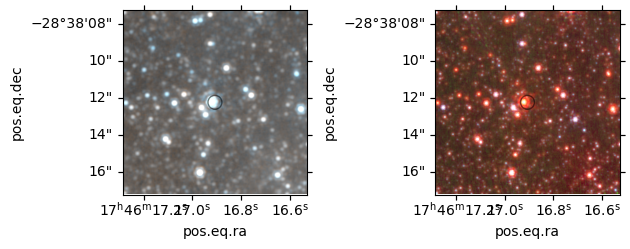

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


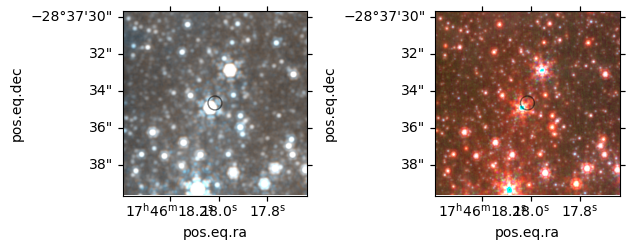

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


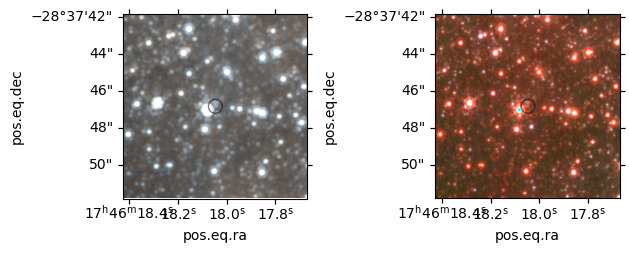

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


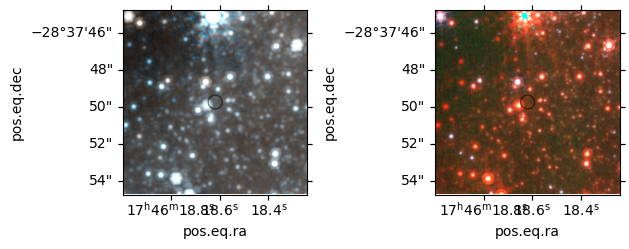

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


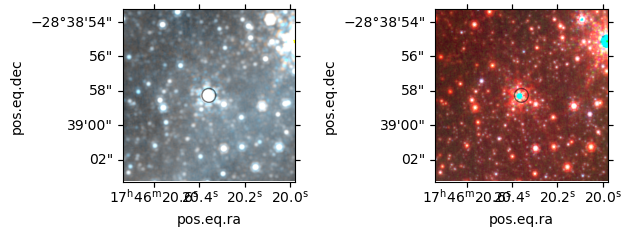

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


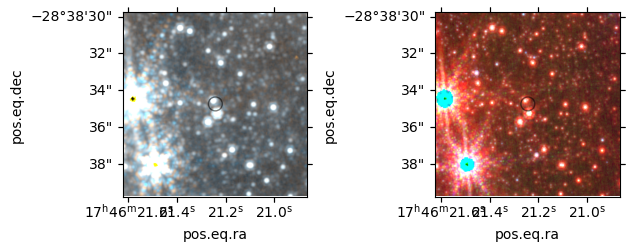

In [74]:
for i in range(len(spicy_filament_positions)):
    cutout, ww = cm.get_cutout_rgb(spicy_filament_positions[i], 10*u.arcsec, 10*u.arcsec)
    ax = plt.subplot(121, projection=ww)
    ax.imshow(cutout.data, origin='lower', cmap='Greys', vmin=0, vmax=50)
    ax.scatter(spicy_filament_positions[i].ra, spicy_filament_positions[i].dec, s=100, edgecolor='k', facecolor='none', alpha=0.5, transform=ax.get_transform('world'))
    cutout, ww = cm.get_cutout_rgb3(spicy_filament_positions[i], 10*u.arcsec, 10*u.arcsec)
    ax = plt.subplot(122, projection=ww)
    ax.imshow(cutout.data, origin='lower', cmap='Greys', vmin=0, vmax=50)
    ax.scatter(spicy_filament_positions[i].ra, spicy_filament_positions[i].dec, s=100, edgecolor='k', facecolor='none', alpha=0.5, transform=ax.get_transform('world'))
    plt.tight_layout()
    plt.show()

In [78]:
cutout, ww = cm.get_cutout_rgb(mass_cat1_pos[0], 10*u.arcsec, 10*u.arcsec)
ax = plt.subplot(111, projection=ww)
ax.imshow(cutout.data, origin='lower', cmap='Greys', vmin=0, vmax=50)
ax.scatter(mass_cat1_pos[0].ra, mass_cat1_pos[0].dec, s=100, edgecolor='k', facecolor='none', alpha=0.5, transform=ax.get_transform('world'))

ValueError: Input position contains invalid values (NaNs or infs).

<SkyCoord (ICRS): (ra, dec) in deg
    (17.77176944, -28.63988889)>